In [1]:
from typing import Callable, Tuple, List, Union
import os
import random
import functools

from tqdm.notebook import tqdm as tqdm

import pandas as pd
import numpy as np

import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
df_text = pd.read_csv('df_text.csv')

df_labels = pd.read_csv(os.path.join(os.getcwd(), 'MOSI', 'labels.csv'))

df_labels['Label'] = df_labels['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

df = pd.merge(
    df_labels[['Filename', 'Type', 'Label']], 
    df_text[['Filename', 'Text', 'Nwords']],
    how='left',
    on='Filename'
)
df.head()

Filename   Type  Label  \
0  03bSnISJMiM_1  train      1   
1  03bSnISJMiM_2  train      0   
2  03bSnISJMiM_3  train      0   
3  03bSnISJMiM_4  train      0   
4  03bSnISJMiM_5  train      1   

                                                Text  Nwords  
0                          anyhow it was really good       5  
1  they did they didn't it really do a whole bunc...      21  
2                  i mean you did a little bit of it       9  
3             but not a whole oneun they should have       8  
4                                  i guess is su ter       5

In [3]:
df.isnull().sum()

Filename    0
Type        0
Label       0
Text        1
Nwords      0
dtype: int64

In [4]:
df.loc[~(df['Text'].notnull())]

Filename  Type  Label Text  Nwords
2034  tmZoasNr4rU_18  test      1  NaN       1

In [5]:
# I will not use this test example

df = df.loc[(df['Text'].notnull())].reset_index(drop=True).copy()

In [6]:
print(f"Min. number of words in a sentence is {df.loc[(df['Type'] == 'train'),'Nwords'].min()}")
print(f"Max. number of words in a sentence is {df.loc[(df['Type'] == 'train'), 'Nwords'].max()}")
print(f"Average number of words in a sentence is {df.loc[(df['Type'] == 'train'), 'Nwords'].mean():.3f}")

Min. number of words in a sentence is 1
Max. number of words in a sentence is 152
Average number of words in a sentence is 11.161


## Train, valid and test sets have similar label distribution

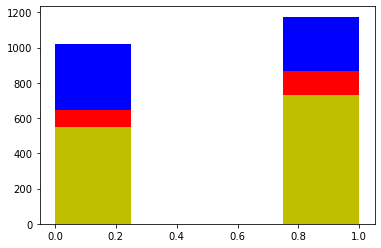

In [7]:
dataset_names = ['train', 'valid', 'test']

dataframes = {
    dn: df.loc[(df['Type'] == dn)].reset_index(drop=True).copy() for dn in dataset_names
}

labels_distribution = [dataframes[dn]['Label'].tolist() for dn in dataset_names]

plt.figure(figsize=(6,4))
fig = plt.hist(
    labels_distribution, 
    stacked=True,
    bins=4,
    color=['y','r','b'],
    label=dataset_names
)
plt.show()

## I will conduct different kind of experiments. 

## 1. experiment will compare models by creating a vocabulary only from the tokens that ## appear in the train set. Glove6B with 100 dimensions and Glove6B with 300 dimensions
## embeddings will be used for word2vec operations.

## 2. experiment will pretrain the models on the IMDB movie reviews dataset. It will then
## perform inferences on both the train, validation and test sets, without training.

## 3. experiment will use the pretrained models on IMDB, but it will fine-tune the models
## on the MOSI dataset.

In [8]:
def get_vocab(df: pd.DataFrame, tokenizer: Callable, preprocess: Callable = None) -> Tuple[torchtext.vocab.vocab, int]:
    """Creates a vocabulary from the tokens that appear
    in the train set.
    
    Args:
        df: contains the texts for each dataset
        tokenizer: function that performs tokenization
        preprocess: function that can be called after tokenization! 
                    (mainly used to generate bi-grams)
    
    Returns:
        built vocabulary and the pad index
    """
    example_text = df['Text'][0]

    print(f'Example text: {example_text}\n\nTokenized text: {tokenizer(example_text)}\n')
    
    train_tokens = [
        preprocess(tokenizer(i)) if preprocess else tokenizer(i) for i in df.loc[
            (df['Type'] == 'train'), 
            'Text'
        ].tolist()
    ]
    unique_tokens = set([j for i in train_tokens for j in i])

    print(f'Number of unique tokens is {len(unique_tokens)}\n')
    
    # Because the number of unique tokens is very small ...
    min_freq = 1
    special_tokens = ['<unk>', '<pad>']

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_freq,
        specials=special_tokens
    )
    print(f'Cardinality of vocabulariy is {len(vocab)}\n')
    # Get missing token index and pad index
    unk_index = vocab['<unk>']
    pad_index = vocab['<pad>']

    vocab.set_default_index(unk_index)
    print(f"Default index of missing token is {vocab['some_token']}")
    
    return vocab, pad_index

'''
This dataset is designed to maximalize the length of the sequences that appear in each text.
If the length of the sentence is greater than max_length, then an index is randomly choosen to start
the sentence from and it lasts until the index + max_length.
''' 
class TextDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, tokenizer, max_length, vocab, preprocess=None):
        # preprocess is a function that can be called after tokenization! 
         # (mainly used to generate bi-grams)
        
        self.texts = list(map(
            lambda x: preprocess(tokenizer(x)) if preprocess else tokenizer(x), 
            df['Text'].tolist()
        ))
        self.numericalized = [list(map(lambda x: vocab[x], i)) for i in self.texts]
        self.labels = df['Label'].tolist()
        self.max_length = max_length
        
    def __len__(self):
        
        return len(self.texts)
    
    def __getitem__(self, idx):
        
        n_ids = len(self.numericalized[idx])
        
        if n_ids > self.max_length:
            start_index = random.choice(range(n_ids - self.max_length))
            ids = torch.tensor(self.numericalized[idx][start_index: start_index + self.max_length])
        else:
            ids = torch.tensor(self.numericalized[idx])
        
        label = torch.tensor(self.labels[idx])
        length_ids = torch.tensor(len(ids))
        
        sample = {'ids': ids, 'label': label, 'length': length_ids}
        
        return sample
    
'''
Lengths are needed to avoid superfluous gradient updates at positions where padding is used.
'''

def collate_fn(batch, pad_index):
    
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {
        'ids': batch_ids,
        'length': batch_length,
        'label': batch_label
    }
    return batch


def train(dataloader, model, criterion, optimizer, device):
    
    model.train()
    epoch_losses = []
    epoch_accs = []
    
    for batch in dataloader:
        
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        length = batch['length']
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)


def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []
    
    with torch.no_grad():
        
        for batch in dataloader:
            
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            length = batch['length']
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction ,label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)


def get_accuracy(prediction, label):
    
    batch_size, _ = prediction.shape
    predicted_classes = torch.sigmoid(prediction).argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    
    return accuracy

In [9]:
'''
Architecture is similar to the original CBoW/Skip-gram with added pooling to average the word vectors.

https://arxiv.org/pdf/1301.3781.pdf 
'''
class CBoW(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        
        super().__init__()       
        # if padding_idx is specified the attributes do not contribute to the gradient at padding_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, ids, *args):

        embedded = self.embedding(ids)
        pooled = embedded.mean(dim=1)
        prediction = self.fc(pooled)
        
        return prediction
    
    
'''
Simple RNN
'''
class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_index):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, *args):

        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))
    
    
# https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch

class LSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, ids, length, *args):
        
        embedded = self.dropout(self.embedding(ids))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, 
            length, 
            batch_first=True,
            enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
    
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
            
        prediction = self.fc(hidden)
        
        return prediction

    
# Bag of Tricks: https://arxiv.org/pdf/1607.01759.pdf
    
class FastText(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dimm, pad_index):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text, *args):
        
        embedded = self.embedding(text)
        pooled = torch.mean(embedded, axis=1).squeeze(1)
        
        return self.fc(pooled)


# CNNs for sentence classificatin: https://arxiv.org/pdf/1408.5882.pdf
    
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_index):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels = 1, 
                out_channels = n_filters, 
                kernel_size = (fs, embedding_dim)
            ) for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, *args):

        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))

        return self.fc(cat)
    
    
def generate_bigrams(x):
    
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    
    return x


def initialize_weights(m):
    
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)
                
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [10]:
def plot_results(
    res: dict,
    n_epochs: int,
    keys: List, 
    title: str, 
    y_titles: List,
    width: int,
    height: int,
    legend_gap: int,
    break_at: Union[int, None] = None
) -> None:
    """
    """
    fig = make_subplots(
    rows=2, 
    cols=1, 
    )
    for i, (exp, res) in enumerate(res.items()):

        fig.append_trace(
            go.Scatter(
                x=list(range(1, n_epochs + 1)), 
                y=res[keys[0]], 
                name=exp,
                legendgroup=1,
            ),
            row=1,
            col=1
        )
        fig.append_trace(
            go.Scatter(
                x=list(range(1, n_epochs + 1)), 
                y=res[keys[1]], 
                name=exp,
                legendgroup=2,
            ),
            row=2,
            col=1
        )
        if i == break_at:
            break
        

    fig.update_layout(
        title=title, 
        xaxis2_title='epochs',
        yaxis1_title=y_titles[0],
        yaxis2_title=y_titles[1],
        autosize=False,
        width=width, 
        height=height,
        legend_tracegroupgap=legend_gap
    )
    fig.show()
    
    
def plot_test_results(
    res: dict, 
    hex_colors: List, 
    break_at: Union[int, None] = None
) -> None:
    """
    """
    test_accs = {
        'experiment_name': [],
        'test_accuracy': []
    }
    for i, (exp, res) in enumerate(res.items()):

        test_accs['experiment_name'].append(exp)
        test_accs['test_accuracy'].append(res['test_acc'])
        
        if i == break_at:
            break

    fig = px.bar(
        test_accs, 
        x='experiment_name', 
        y='test_accuracy', 
        color=test_accs['experiment_name'],
        color_discrete_sequence=random.choices(hex_colors, k=len(test_accs['experiment_name']))
    )
    fig.show()

In [11]:
# dictionary to store all experiment results
results = {}

seed = 2021

torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# Generate colors for the plots
hex_colors_only = []

for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)

In [12]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

vocab, pad_index = get_vocab(df, tokenizer)

max_lengths = [12, 20, 30, 50]
batch_size = 32
vocab_size = len(vocab)
output_dim = df['Label'].nunique()
lr = 1e-4
n_epochs = 100

device = torch.device('cuda')

path_saved_models = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(path_saved_models):
    os.mkdir(path_saved_models)


exp_results = {}

embeddings = {
    'Glove6B100': {
        'name': '6B', 
        'dim': 100
    },
    'Glove6B300': {
        'name': '6B', 
        'dim': 300
    }
}
    
for emb, params in embeddings.items():

    embedding_dim = params['dim']
    vectors = torchtext.vocab.GloVe(**params)
    pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
    
    for ml in max_lengths:    
        
        exp_name = f'NBoW_emb_{emb}_max_length_{ml}'
        path_model = os.path.join(path_saved_models, f'{exp_name}.pt')
        
        datasets = {
            dn: TextDataset(dataframes[dn], tokenizer, ml, vocab) for dn in dataset_names
        }
        collate = functools.partial(collate_fn, pad_index=pad_index)

        data_loaders = {
            dn: DataLoader(
                datasets[dn], 
                batch_size=batch_size, 
                collate_fn=collate, 
                shuffle=True
            ) for dn in dataset_names
        }

        model = CBoW(vocab_size, embedding_dim, output_dim, pad_index)
        model.apply(initialize_weights)
        
        # Replace model embedding weights with the pretrained weights
        model.embedding.weight.data = pretrained_embedding

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model = model.to(device)
        criterion = criterion.to(device)

        best_valid_loss = float('inf')

        train_losses = []
        train_accs = []
        valid_losses = []
        valid_accs = []

        for epoch in range(n_epochs):

            train_loss, train_acc = train(data_loaders['train'], model, criterion, optimizer, device)
            valid_loss, valid_acc = evaluate(data_loaders['valid'], model, criterion, device)

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            if valid_loss < best_valid_loss:

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), path_model)

        model.load_state_dict(torch.load(path_model))
        test_loss, test_acc = evaluate(data_loaders['test'], model, criterion, device)

        exp_results.update({
            exp_name: {
                'train_loss': train_losses,
                'train_acc': train_accs,
                'valid_loss': valid_losses,
                'valid_acc': valid_accs,
                'test_loss': test_loss,
                'test_acc': test_acc
            }
        })


    results.update(exp_results)

Example text: anyhow it was really good

Tokenized text: ['anyhow', 'it', 'was', 'really', 'good']

Number of unique tokens is 2700

Cardinality of vocabulariy is 2702

Default index of missing token is 0


In [13]:
plot_results(
    res=results,
    n_epochs=n_epochs,
    keys=['train_loss', 'valid_loss'], 
    title='Train & validation loss of each experiment',
    y_titles=['Train CrossEntropyLoss', 'Validation crossEntropyLoss'],
    width=900, 
    height=800,
    legend_gap=260,
)

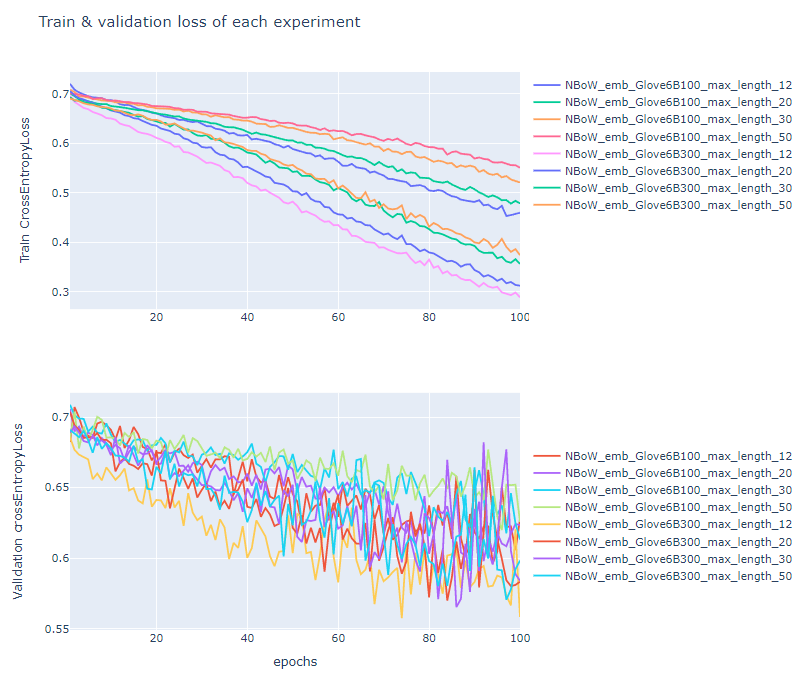

In [14]:
plot_results(
    res=results,
    n_epochs=n_epochs,
    keys=['train_acc', 'valid_acc'], 
    title='Train & validation accuracy of each experiment',
    y_titles=['Train accuracy', 'Validation accuracy'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

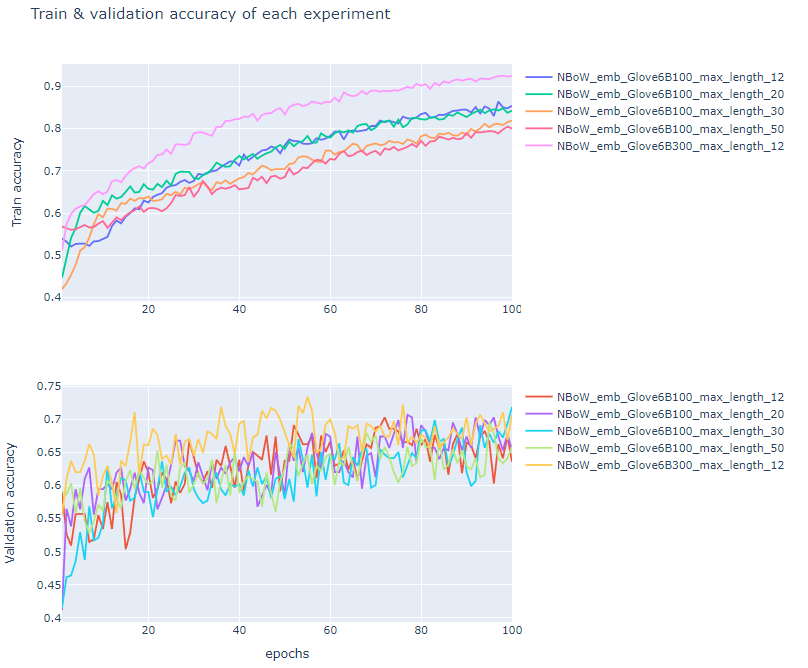

## Models tend to overtfit from around ~30-40 epochs. The test results are calculated
## by loading the weights where the validation score was the best.

In [15]:
plot_test_results(results, hex_colors_only)

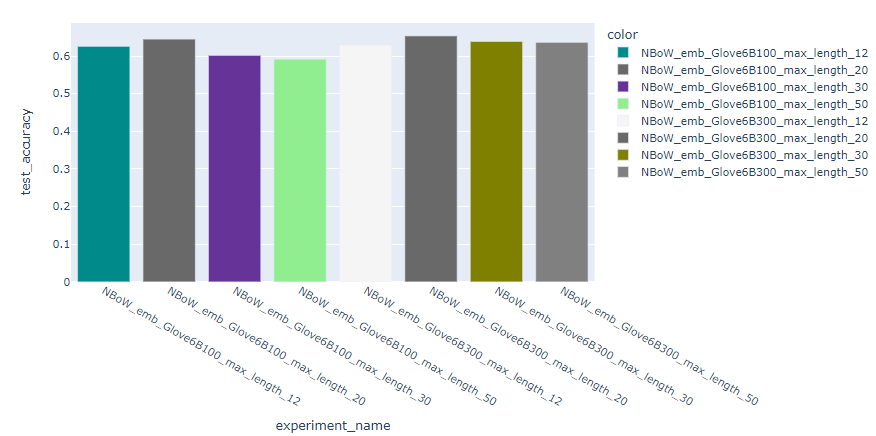

In [16]:
# I will abbreviate max length and hidden dim when saving and displaying

max_lengths = [12, 20, 30]
batch_size = 32
vocab_size = len(vocab)
hidden_dims = [16, 32, 64]
output_dim = df['Label'].nunique()

lr = 1e-4
n_epochs = 40

device = torch.device('cuda')

exp_results = {}


for emb, params in embeddings.items():

    embedding_dim = params['dim']
    vectors = torchtext.vocab.GloVe(**params)
    pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
    
    for ml in max_lengths:
        
        datasets = {
            dn: TextDataset(dataframes[dn], tokenizer, ml, vocab) for dn in dataset_names
        }
        collate = functools.partial(collate_fn, pad_index=pad_index)

        data_loaders = {
            dn: DataLoader(
                datasets[dn], 
                batch_size=batch_size, 
                collate_fn=collate, 
                shuffle=True
            ) for dn in dataset_names
        }
        
        for hm in hidden_dims:

            exp_name = f'RNN_emb_{emb}_ml_{ml}_hd_{hm}'
            path_model = os.path.join(path_saved_models, f'{exp_name}.pt')

            model = RNN(vocab_size, embedding_dim, hm, output_dim, pad_index=pad_index)
            model.apply(initialize_weights)
            
            # Replace model embedding weights with the pretrained weights
            model.embedding.weight.data = pretrained_embedding

            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            model = model.to(device)
            criterion = criterion.to(device)

            best_valid_loss = float('inf')

            train_losses = []
            train_accs = []
            valid_losses = []
            valid_accs = []

            for epoch in range(n_epochs):

                train_loss, train_acc = train(data_loaders['train'], model, criterion, optimizer, device)
                valid_loss, valid_acc = evaluate(data_loaders['valid'], model, criterion, device)

                train_losses.append(train_loss)
                train_accs.append(train_acc)
                valid_losses.append(valid_loss)
                valid_accs.append(valid_acc)

                if valid_loss < best_valid_loss:

                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), path_model)

            model.load_state_dict(torch.load(path_model))
            test_loss, test_acc = evaluate(data_loaders['test'], model, criterion, device)
            
            exp_results.update({
                exp_name: {
                    'train_loss': train_losses,
                    'train_acc': train_accs,
                    'valid_loss': valid_losses,
                    'valid_acc': valid_accs,
                    'test_loss': test_loss,
                    'test_acc': test_acc
                }
            })


results.update(exp_results)

In [17]:
results_rnn = dict(filter(lambda x: 'RNN' in x[0], results.items()))

# python 3.7+ dictionary preserves insertion order 
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
results_rnn = dict(sorted(results_rnn.items(), key=lambda x: x[1]['test_acc'], reverse=True))

In [18]:
plot_results(
    res=results_rnn,
    n_epochs=n_epochs,
    keys=['train_loss', 'valid_loss'], 
    title='Train & validation loss of each experiment',
    y_titles=['Train CrossEntropyLoss', 'Validation crossEntropyLoss'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

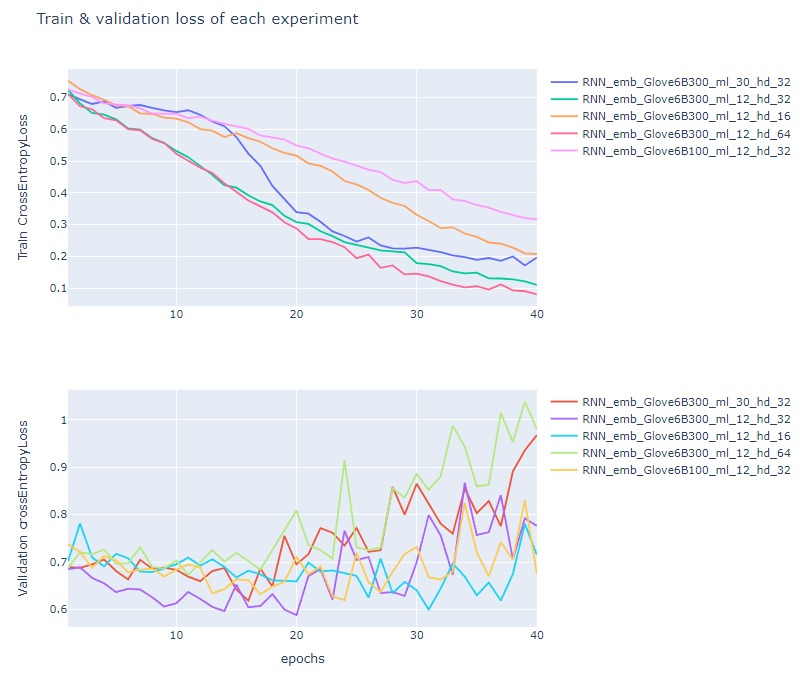

In [19]:
plot_results(
    res=results_rnn,
    n_epochs=n_epochs,
    keys=['train_acc', 'valid_acc'], 
    title='Train & validation accuracy of each experiment',
    y_titles=['Train accuracy', 'Validation accuracy'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

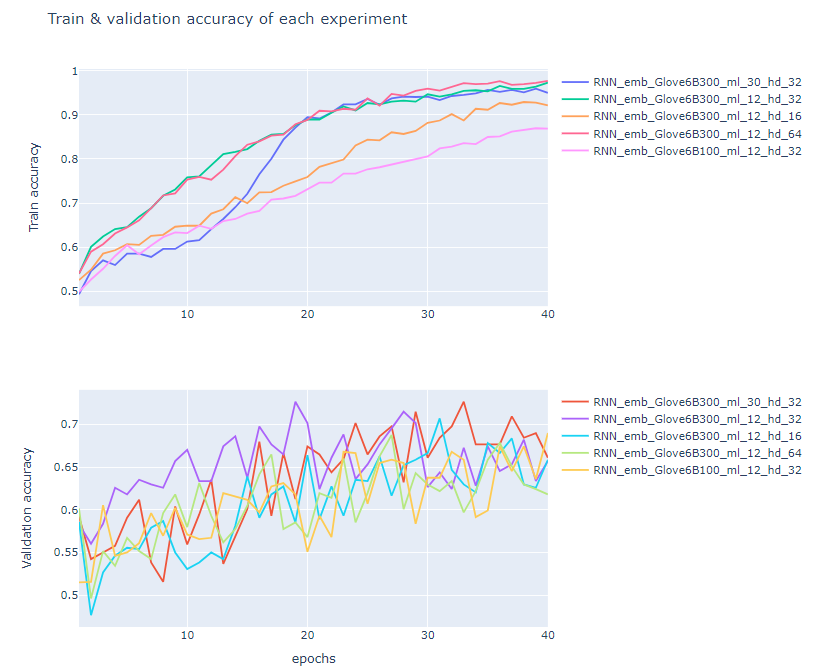

In [20]:
plot_test_results(results_rnn, hex_colors_only, 4)

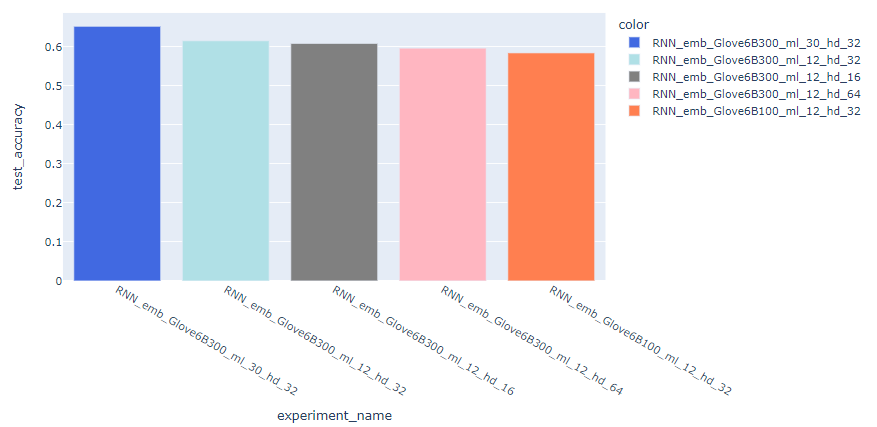

## The 5 best results are shown according to the test results. Models overfit fast. 
## RNN training is unstable compared to the CBoW. At the end it provides roughly
## identical test results

In [21]:
max_lengths = [12, 20, 30]
batch_size = 32
vocab_size = len(vocab)
hidden_dims = [16, 32, 64]
output_dim = df['Label'].nunique()
n_layers = 2
bidirectional = [False, True]
dropout_rate = 0.5

lr = 1e-4
n_epochs = 40

device = torch.device('cuda')

exp_results = {}


for emb, params in embeddings.items():
    
    embedding_dim = params['dim']
    vectors = torchtext.vocab.GloVe(**params)
    pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
    
    for bd in bidirectional:
    
        for ml in max_lengths:

            datasets = {
                dn: TextDataset(dataframes[dn], tokenizer, ml, vocab) for dn in dataset_names
            }
            collate = functools.partial(collate_fn, pad_index=pad_index)

            data_loaders = {
                dn: DataLoader(
                    datasets[dn], 
                    batch_size=batch_size, 
                    collate_fn=collate, 
                    shuffle=True
                ) for dn in dataset_names
            }

            for hm in hidden_dims:

                exp_name = f'LSTM_emb_{emb}_bidir_{bd}_ml_{ml}_hd_{hm}'
                path_model = os.path.join(path_saved_models, f'{exp_name}.pt')

                model = LSTM(
                    vocab_size, 
                    embedding_dim, 
                    hm, 
                    output_dim, 
                    n_layers,
                    bd,
                    dropout_rate,
                    pad_index=pad_index
                )
                model.apply(initialize_weights)
                # Replace model embedding weights with the pretrained weights
                model.embedding.weight.data = pretrained_embedding

                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.CrossEntropyLoss()

                model = model.to(device)
                criterion = criterion.to(device)

                best_valid_loss = float('inf')

                train_losses = []
                train_accs = []
                valid_losses = []
                valid_accs = []

                for epoch in range(n_epochs):

                    train_loss, train_acc = train(data_loaders['train'], model, criterion, optimizer, device)
                    valid_loss, valid_acc = evaluate(data_loaders['valid'], model, criterion, device)

                    train_losses.append(train_loss)
                    train_accs.append(train_acc)
                    valid_losses.append(valid_loss)
                    valid_accs.append(valid_acc)

                    if valid_loss < best_valid_loss:

                        best_valid_loss = valid_loss
                        torch.save(model.state_dict(), path_model)

                model.load_state_dict(torch.load(path_model))
                test_loss, test_acc = evaluate(data_loaders['test'], model, criterion, device)
                
                exp_results.update({
                    exp_name: {
                        'train_loss': train_losses,
                        'train_acc': train_accs,
                        'valid_loss': valid_losses,
                        'valid_acc': valid_accs,
                        'test_loss': test_loss,
                        'test_acc': test_acc
                    }
                })


results.update(exp_results)

In [22]:
results_lstm = dict(filter(lambda x: 'LSTM' in x[0], results.items()))

results_lstm = dict(sorted(results_lstm.items(), key=lambda x: x[1]['test_acc'], reverse=True))

In [23]:
plot_results(
    res=results_lstm,
    n_epochs=n_epochs,
    keys=['train_loss', 'valid_loss'], 
    title='Train & validation loss of each experiment',
    y_titles=['Train CrossEntropyLoss', 'Validation crossEntropyLoss'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

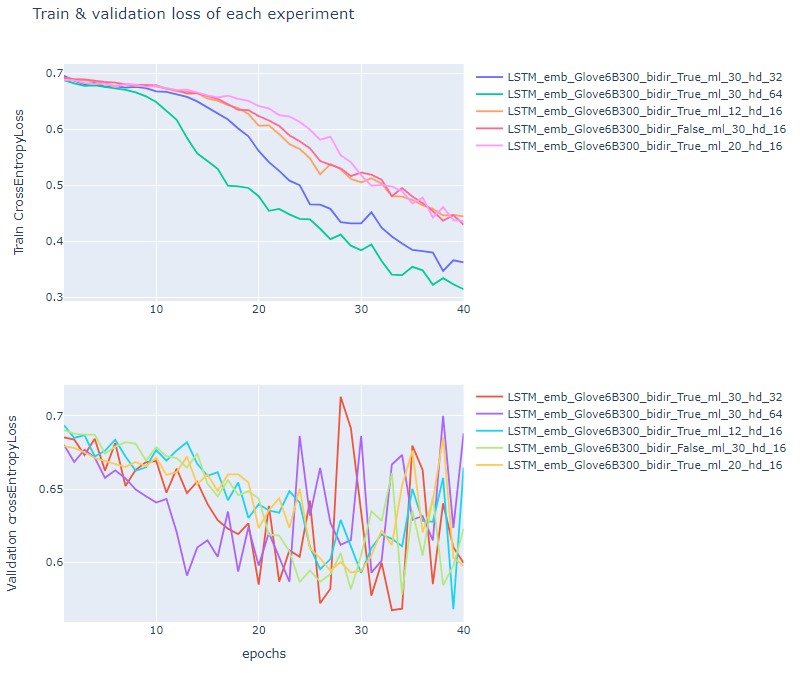

In [24]:
plot_results(
    res=results_lstm,
    n_epochs=n_epochs,
    keys=['train_acc', 'valid_acc'], 
    title='Train & validation accuracy of each experiment',
    y_titles=['Train accuracy', 'Validation accuracy'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

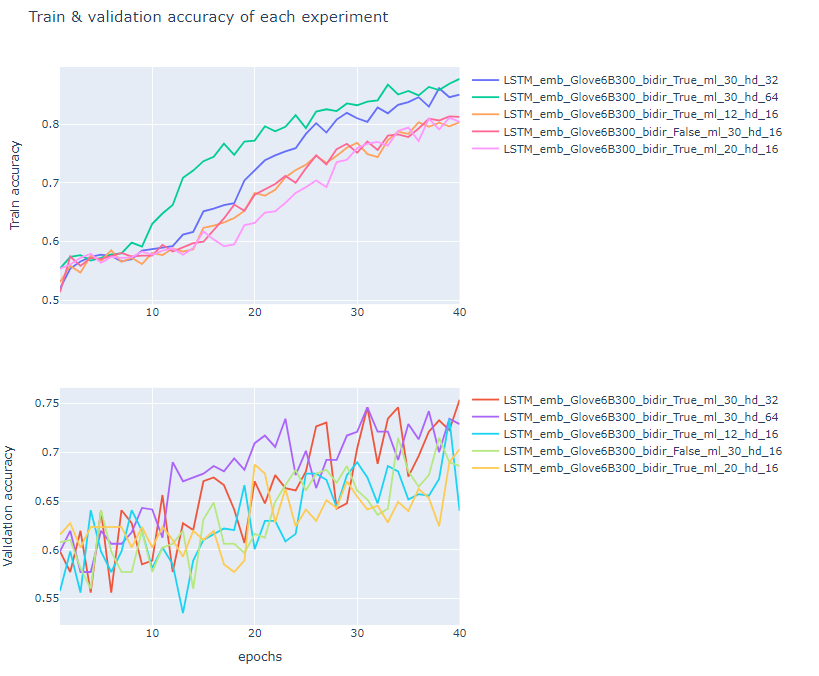

In [25]:
plot_test_results(results_lstm, hex_colors_only, 4)

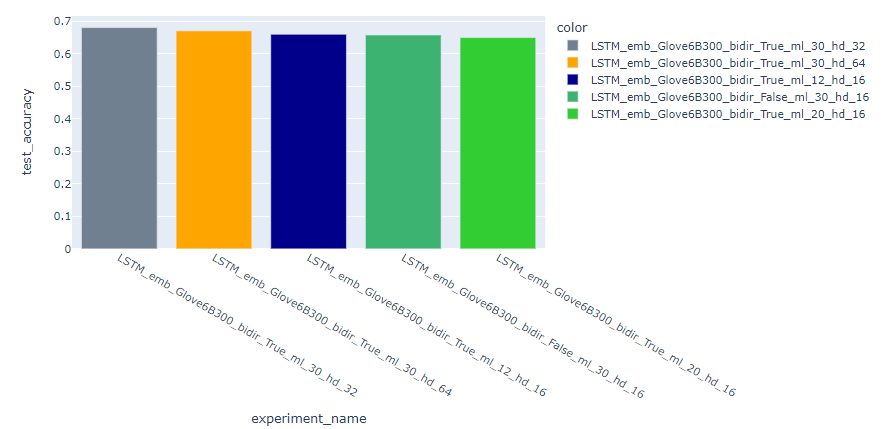

## In this case it is more visible that LSTM models overfit from around ~20 epochs.
## There is still no advancement compared to the simpler models.

In [26]:
# Compared to CBoW the difference here is the usage of bi-grams
# Rebuild the vocabulary with the use of bi-grams 
# Pass the generate_bigrams function to the dataset constructor as well!

tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

vocab, pad_index = get_vocab(df, tokenizer, generate_bigrams)

max_lengths = [12, 20, 30]
batch_size = 32
vocab_size = len(vocab)
output_dim = df['Label'].nunique()

lr = 1e-4
n_epochs = 100

device = torch.device('cuda')

exp_results = {}


for emb, params in embeddings.items():

    embedding_dim = params['dim']
    vectors = torchtext.vocab.GloVe(**params)
    pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
    
    for ml in max_lengths:
        
        datasets = {
            dn: TextDataset(
                dataframes[dn], 
                tokenizer, 
                ml, 
                vocab, 
                generate_bigrams
            ) for dn in dataset_names
        }
        collate = functools.partial(collate_fn, pad_index=pad_index)

        data_loaders = {
            dn: DataLoader(
                datasets[dn], 
                batch_size=batch_size, 
                collate_fn=collate, 
                shuffle=True
            ) for dn in dataset_names
        }
        
        exp_name = f'FastText_emb_{emb}_ml_{ml}'
        path_model = os.path.join(path_saved_models, f'{exp_name}.pt')

        model = FastText(
            vocab_size, 
            embedding_dim, 
            output_dim, 
            pad_index=pad_index
        )
        model.apply(initialize_weights)
        
        # Replace model embedding weights with the pretrained weights
        model.embedding.weight.data = pretrained_embedding

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model = model.to(device)
        criterion = criterion.to(device)

        best_valid_loss = float('inf')

        train_losses = []
        train_accs = []
        valid_losses = []
        valid_accs = []

        for epoch in range(n_epochs):

            train_loss, train_acc = train(data_loaders['train'], model, criterion, optimizer, device)
            valid_loss, valid_acc = evaluate(data_loaders['valid'], model, criterion, device)

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            if valid_loss < best_valid_loss:

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), path_model)

        model.load_state_dict(torch.load(path_model))
        test_loss, test_acc = evaluate(data_loaders['test'], model, criterion, device)

        exp_results.update({
            exp_name: {
                'train_loss': train_losses,
                'train_acc': train_accs,
                'valid_loss': valid_losses,
                'valid_acc': valid_accs,
                'test_loss': test_loss,
                'test_acc': test_acc
            }
        })


results.update(exp_results)

Example text: anyhow it was really good

Tokenized text: ['anyhow', 'it', 'was', 'really', 'good']

Number of unique tokens is 11222

Cardinality of vocabulariy is 11224

Default index of missing token is 0


In [27]:
datasets['test'].texts[0]

['oh',
 'my',
 'gosh',
 'bad',
 'movie',
 'gosh bad',
 'bad movie',
 'oh my',
 'my gosh']

In [28]:
results_fasttext = dict(filter(lambda x: 'FastText' in x[0], results.items()))

results_fasttext = dict(sorted(results_fasttext.items(), key=lambda x: x[1]['test_acc'], reverse=True))

In [29]:
plot_results(
    res=results_fasttext,
    n_epochs=n_epochs,
    keys=['train_loss', 'valid_loss'], 
    title='Train & validation loss of each experiment',
    y_titles=['Train CrossEntropyLoss', 'Validation crossEntropyLoss'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

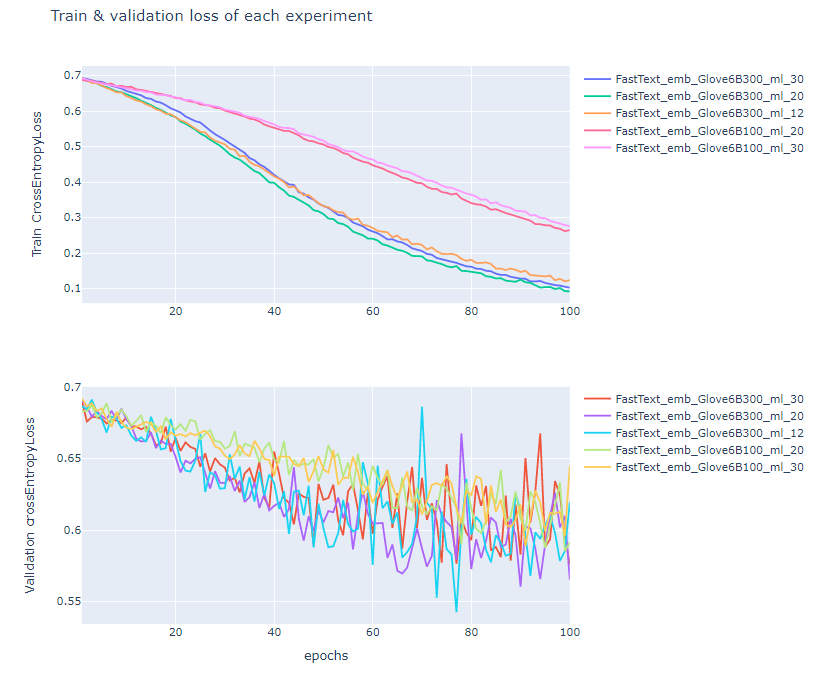

In [30]:
plot_results(
    res=results_fasttext,
    n_epochs=n_epochs,
    keys=['train_acc', 'valid_acc'], 
    title='Train & validation accuracy of each experiment',
    y_titles=['Train accuracy', 'Validation accuracy'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

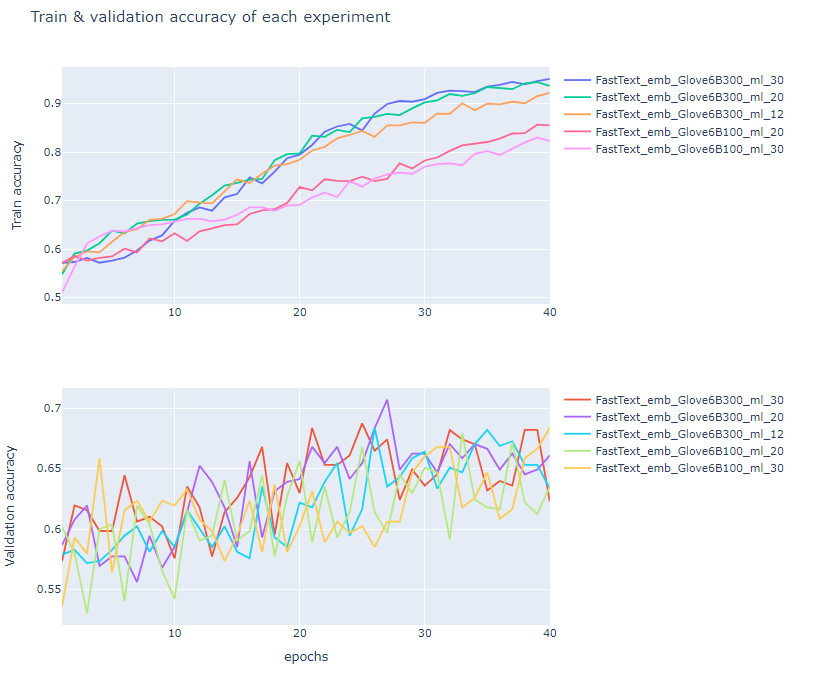

In [31]:
plot_test_results(results_fasttext, hex_colors_only, 4)

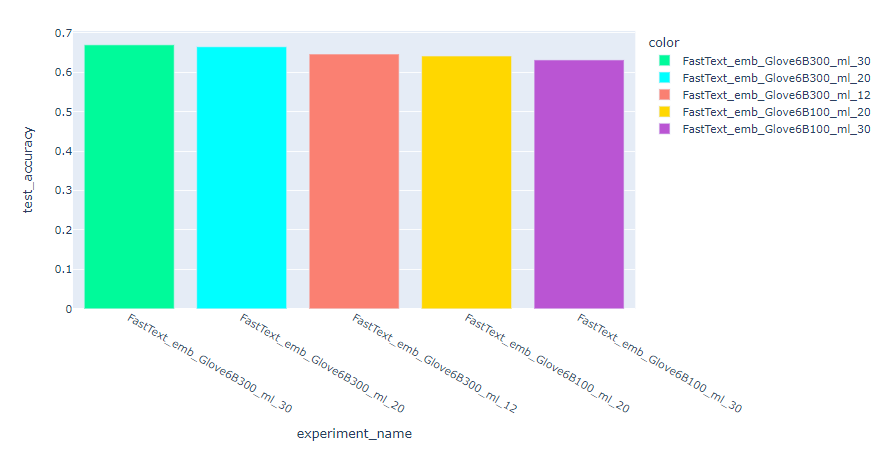

## Models overfit from around ~ 20 epochs. Results are roughly on pair with the
## previous ones

In [32]:
vocab, pad_index = get_vocab(df, tokenizer)

max_lengths = [12, 20, 30]
batch_size = 32
vocab_size = len(vocab)
n_filters = 100
filter_sizes = [3,5]
dropout_rate = 0.25
output_dim = df['Label'].nunique()

lr = 1e-4
n_epochs = 40

device = torch.device('cuda')

exp_results = {}


for emb, params in embeddings.items():

    embedding_dim = params['dim']
    vectors = torchtext.vocab.GloVe(**params)
    pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
    
    for ml in max_lengths:
        
        datasets = {
            dn: TextDataset(
                dataframes[dn], 
                tokenizer, 
                ml, 
                vocab
            ) for dn in dataset_names
        }
        collate = functools.partial(collate_fn, pad_index=pad_index)

        data_loaders = {
            dn: DataLoader(
                datasets[dn], 
                batch_size=batch_size, 
                collate_fn=collate, 
                shuffle=True
            ) for dn in dataset_names
        }
        
        exp_name = f'CNN_emb_{emb}_ml_{ml}'
        path_model = os.path.join(path_saved_models, f'{exp_name}.pt')

        model = CNN(
            vocab_size, 
            embedding_dim,
            n_filters,
            filter_sizes,
            output_dim,
            dropout_rate,
            pad_index
        )
        model.apply(initialize_weights)
        
        # Replace model embedding weights with the pretrained weights
        model.embedding.weight.data = pretrained_embedding

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model = model.to(device)
        criterion = criterion.to(device)

        best_valid_loss = float('inf')

        train_losses = []
        train_accs = []
        valid_losses = []
        valid_accs = []

        for epoch in range(n_epochs):

            train_loss, train_acc = train(data_loaders['train'], model, criterion, optimizer, device)
            valid_loss, valid_acc = evaluate(data_loaders['valid'], model, criterion, device)

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            if valid_loss < best_valid_loss:

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), path_model)

        model.load_state_dict(torch.load(path_model))
        test_loss, test_acc = evaluate(data_loaders['test'], model, criterion, device)

        exp_results.update({
            exp_name: {
                'train_loss': train_losses,
                'train_acc': train_accs,
                'valid_loss': valid_losses,
                'valid_acc': valid_accs,
                'test_loss': test_loss,
                'test_acc': test_acc
            }
        })


results.update(exp_results)

Example text: anyhow it was really good

Tokenized text: ['anyhow', 'it', 'was', 'really', 'good']

Number of unique tokens is 2700

Cardinality of vocabulariy is 2702

Default index of missing token is 0


In [33]:
results_cnn = dict(filter(lambda x: 'CNN' in x[0], results.items()))

results_cnn = dict(sorted(results_cnn.items(), key=lambda x: x[1]['test_acc'], reverse=True))

In [34]:
plot_results(
    res=results_cnn,
    n_epochs=n_epochs,
    keys=['train_loss', 'valid_loss'], 
    title='Train & validation loss of each experiment',
    y_titles=['Train CrossEntropyLoss', 'Validation crossEntropyLoss'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

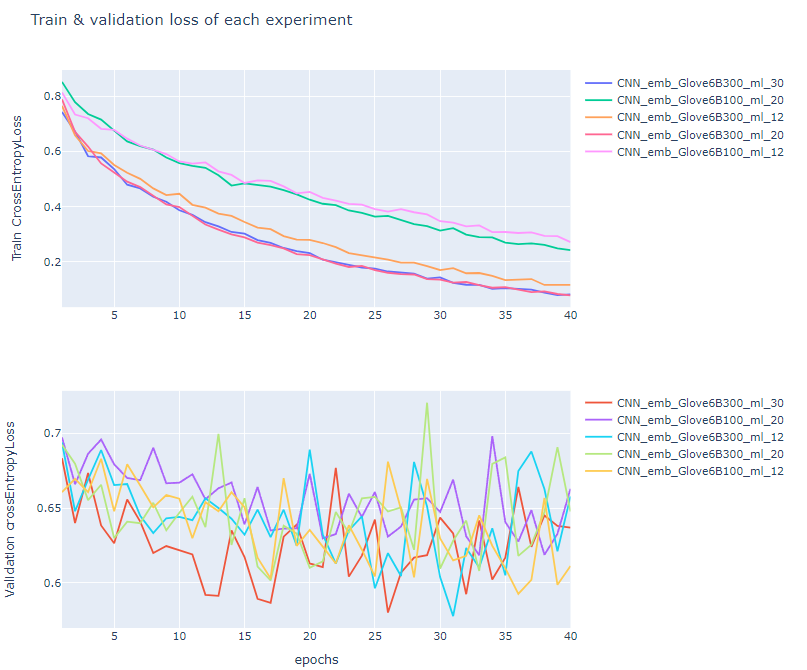

In [35]:
plot_results(
    res=results_cnn,
    n_epochs=n_epochs,
    keys=['train_acc', 'valid_acc'], 
    title='Train & validation accuracy of each experiment',
    y_titles=['Train accuracy', 'Validation accuracy'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=4,
)

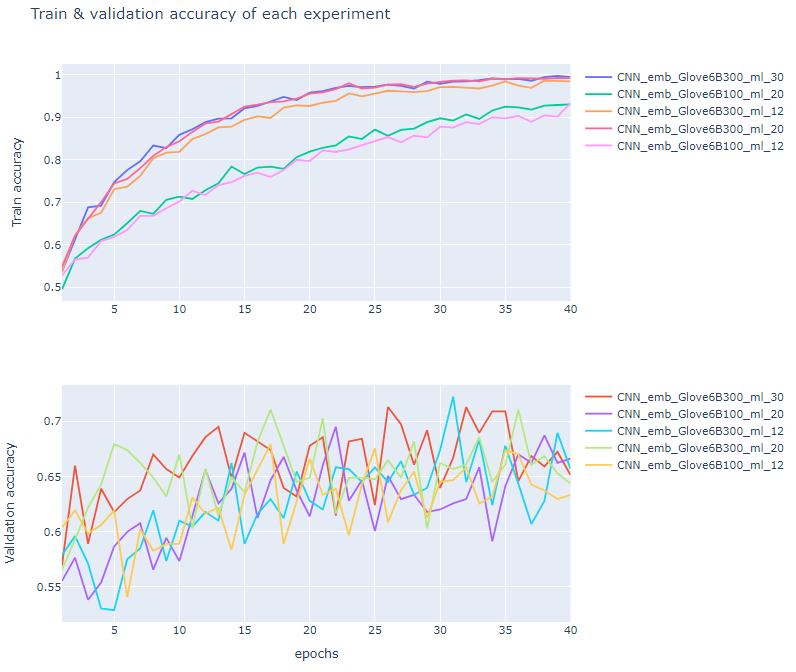

In [36]:
plot_test_results(results_cnn, hex_colors_only, 4)

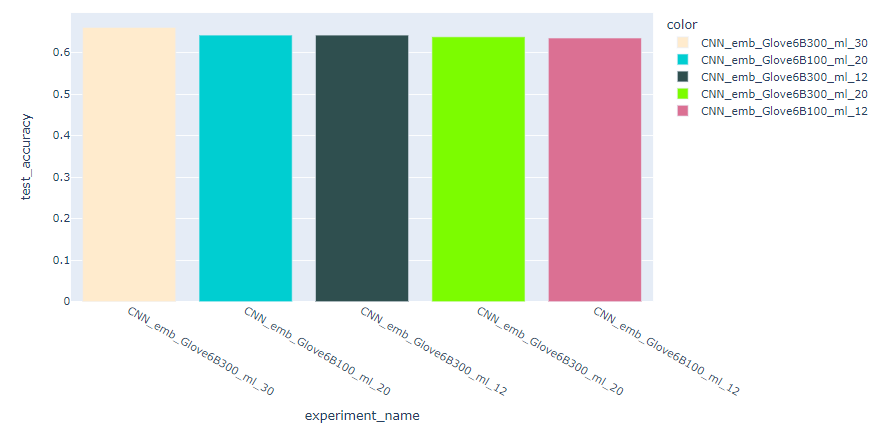

## Models overfit faster. They perform slightly worse than previous architectures.

## Overall conclusion: each architecture performance is roughly the same. Low
## accuracy scores can be related to the differences between the tokens used
## in the training, validation and test sets and also to the very limited data.

In [50]:
results_sorted = dict(sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True))
best_results = {}

for i, (k, v) in enumerate(results_sorted.items()):
    
    best_results[k] = v
    
    if i == 5:
        break

In [52]:
plot_results(
    res=best_results,
    n_epochs=n_epochs,
    keys=['train_acc', 'valid_acc'], 
    title='Train & validation accuracy of each experiment',
    y_titles=['Train accuracy', 'Validation accuracy'],
    width=900, 
    height=800,
    legend_gap=260,
    break_at=None,
)

In [56]:
plot_test_results(best_results, hex_colors_only, 4)

## Top 5 experiments with respect to test accuracy. Bidirectional LSTM with
## 30 max length of sequences and hidden dimension of 32 performed best.